## Name: Jillian DeWoody
## UNI: jd4127

In [29]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.tree import plot_tree

from sklearn.metrics import accuracy_score, brier_score_loss
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import ParameterGrid

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
# from category_encoders import TargetEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.metrics import brier_score_loss
# from sklearn.calibration import CalibratedClassifierCV
# from sklearn.calibration import CalibrationDisplay

import kagglehub
import glob
from pathlib import Path
import matplotlib.image as mpimg
from PIL import Image
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import random

In [31]:
# Ignore (old dataset)

# import kagglehub

# path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

# print("Path to dataset files:", path)


**Run the code below to convert TotalCharges to numeric**


In [34]:
# Ignore (old dataset)

# import glob
# from pathlib import Path

# # types of cancer
# count_class_0 = 0
# count_class_1 = 1

# breast_img_paths = glob.glob('/Users/jilliandewoody/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/**/*.png', recursive = True)

# for img_path in breast_img_paths:
#     if('class0' in img_path):
#         count_class_0 += 1
#     elif('class1' in img_path):
#         count_class_1 += 1

# count_by_class = pd.DataFrame({'Class': ['Non-IDC', 'IDC'], 'Count': [count_class_0, count_class_1]})
# plt.bar(count_by_class['Class'], count_by_class['Count'])
# plt.title("Count of images by class")
# plt.ylabel("Count")
# plt.show()

In [36]:
# Download latest version

path = kagglehub.dataset_download("ambarish/breakhis")

print("Path to dataset files:", path)

Path to dataset files: /Users/jilliandewoody/.cache/kagglehub/datasets/ambarish/breakhis/versions/4


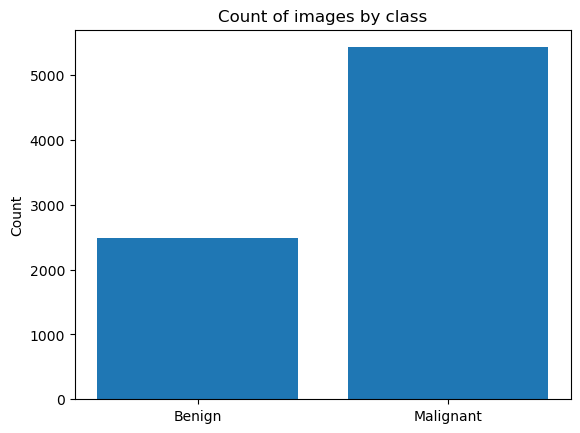

In [38]:
# Update to your local path --> 
random.seed(42)
np.random.seed(42)

img_path = glob.glob('/Users/jilliandewoody/.cache/kagglehub/datasets/ambarish/breakhis/**/*.png', recursive = True)

benign = []
malignant = []

for img in img_path:
    img_name = Path(img).name
    
    if img_name[4] == 'B':
        benign.append(img)
    else:
        malignant.append(img)

count_by_class = pd.DataFrame({'Class': ['Benign', 'Malignant'], 'Count': [len(benign), len(malignant)]})
plt.bar(count_by_class['Class'], count_by_class['Count'])
plt.title("Count of images by class")
plt.ylabel("Count")
plt.show()

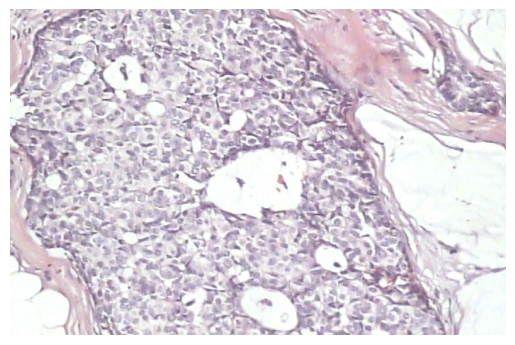

In [40]:
img_benign = mpimg.imread(malignant[1])
plt.imshow(img_benign)
plt.axis("off")  # Hide axes
plt.show()

In [42]:
# # Read and flatten images into a 2D array (each row is a flattened image)


# img = Image.open(benign[0])
# img = img.resize((700, 460))  # Optional: resize images to a consistent size
# img_array = np.array(img)  # Image as (height, width, channels)
# img_array = img_array.flatten()  # Flatten to 1D vector
# print(img_array)

# # scaler = StandardScaler()
# # img_array_scaled = scaler.fit_transform(img_array.reshape(1, -1))

# # print(img_array_scaled)
# # image_arrays = []
# # for img_file in img_path:
# #     img = Image.open(img_file)
# #     img = img.resize((700, 460))  # Optional: resize images to a consistent size
# #     img_array = np.array(img)  # Image as (height, width, channels)
# #     image_arrays.append(img_array.flatten())  # Flatten to 1D vector

# # # Convert list to NumPy array
# # X = np.array(image_arrays)

# # # Optionally, standardize the data (mean=0, std=1)
# # scaler = StandardScaler()
# # X_scaled = scaler.fit_transform(X)

In [44]:
# # Read and flatten images into a 2D array (each row is a flattened image)
# image_arrays = []
# for img_file in img_path[:200]:
#     #img_path_b = os.path.join(folder_path, img_file)
#     img = Image.open(img_file)
#     img = img.resize((700, 460))  # Optional: resize images to a consistent size
#     img_array = np.array(img)  # Image as (height, width, channels)
#     image_arrays.append(img_array.flatten())  # Flatten to 1D vector

# # Convert list to NumPy array
# X = np.array(image_arrays)

# # Optionally, standardize the data (mean=0, std=1)
# # scaler = StandardScaler()
# # X_scaled = scaler.fit_transform(X)

# X_scaled = X/255

# print(X_scaled)

Generating ~3020 augmented images...


  0%|                                                  | 0/2480 [00:00<?, ?it/s]

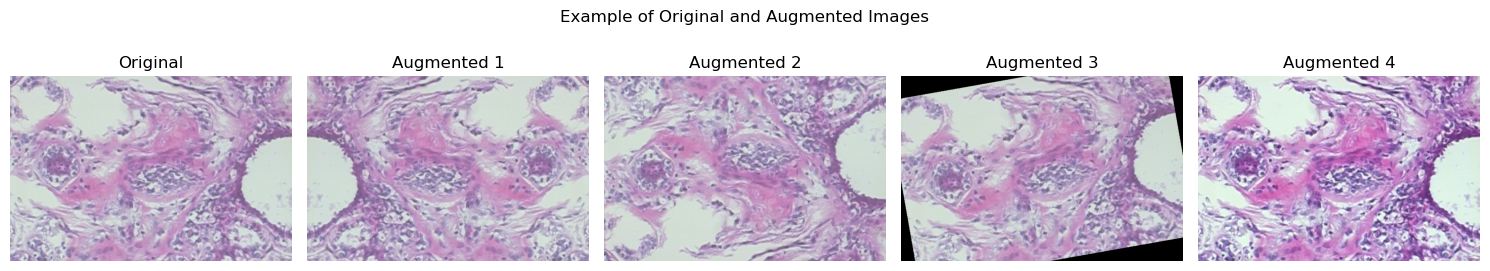

100%|███████████████████████████████████████| 2480/2480 [03:04<00:00, 13.45it/s]

Generated 3020 new benign images.
Total benign images after augmentation: 5500


In [46]:
from tqdm import tqdm
from PIL import Image, ImageEnhance, ImageOps
import random
from pathlib import Path
import os

# Source benign images
benign_images = [img for img in img_path if Path(img).name[4] == 'B']
output_dir = "/Users/jilliandewoody/Documents/augmented_benign"
os.makedirs(output_dir, exist_ok=True)

# Define augmentations
def augment_image(img):
    aug_list = []

    aug_list.append(ImageOps.mirror(img))                      # Horizontal flip
    aug_list.append(ImageOps.flip(img))                        # Vertical flip
    aug_list.append(img.rotate(random.randint(-30, 30)))       # Rotation
    aug_list.append(ImageEnhance.Contrast(img).enhance(1.5))   # Contrast boost

    return aug_list

# Augment benign images to reach ~5500 total
target_total = 5500
n_to_generate = target_total - len(benign_images)
images_needed_per_image = (n_to_generate // len(benign_images)) + 1

print(f"Generating ~{n_to_generate} augmented images...")

augmented_count = 0
for img_path_b in tqdm(benign_images):
    img = Image.open(img_path_b).resize((700, 460))
    augmented_imgs = augment_image(img)

    for aug_img in augmented_imgs[:images_needed_per_image]:
        if augmented_count >= n_to_generate:
            break
        new_name = f"{Path(img_path_b).stem}_aug{augmented_count}.png"
        aug_path = os.path.join(output_dir, new_name)
        aug_img.save(aug_path)

        # ✅ Append to the benign list directly
        benign.append(aug_path)
        if augmented_count == 0:  # Show for first image only
            plt.figure(figsize=(15, 3))
            plt.subplot(1, len(augmented_imgs) + 1, 1)
            plt.imshow(img)
            plt.title("Original")
            plt.axis("off")

            for i, aug_img in enumerate(augmented_imgs):
                plt.subplot(1, len(augmented_imgs) + 1, i + 2)
                plt.imshow(aug_img)
                plt.title(f"Augmented {i+1}")
                plt.axis("off")
            
            plt.suptitle("Example of Original and Augmented Images")
            plt.tight_layout()
            plt.show()
        augmented_count += 1
        

print(f"Generated {augmented_count} new benign images.")
print(f"Total benign images after augmentation: {len(benign)}")


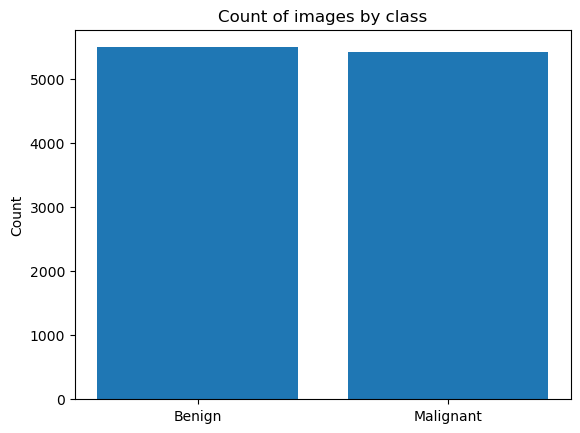

Train: 7654, Val: 1635, Test: 1640


In [48]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

# Step 1: Assign labels and combine
# benign → 0, malignant → 1
#ensure consistency between runs for file crawling
benign = sorted(benign) 
malignant = sorted(malignant) 
image_paths = benign + malignant
labels = [0] * len(benign) + [1] * len(malignant)

# Step 2: Shuffle together to avoid ordering bias
combined = list(zip(image_paths, labels))
random.seed(42)
random.shuffle(combined)
image_paths, labels = zip(*combined)


# combined = list(zip(image_paths, labels))
# random.shuffle(combined)
# image_paths, labels = zip(*combined)  # unzip
# image_paths = list(image_paths)
# labels = list(labels)

# Step 3: Show class distribution
count_by_class = pd.DataFrame({'Class': ['Benign', 'Malignant'], 'Count': [labels.count(0), labels.count(1)]})
plt.bar(count_by_class['Class'], count_by_class['Count'])
plt.title("Count of images by class")
plt.ylabel("Count")
plt.show()

# Step 4: Split dataset (70% train, 15% val, 15% test — stratified)
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels, test_size=0.15, stratify=labels, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42
)  # ≈ 15% of total


print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


In [50]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from PIL import Image
from tqdm import tqdm

# Generator for batch-wise image loading
def image_batch_generator(image_paths, labels, batch_size=32, resize_to=(128, 128)):
    num_samples = len(image_paths)
    while True:  # Infinite generator
        for i in range(0, num_samples, batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]

            batch_images = []
            for path in batch_paths:
                img = Image.open(path).resize(resize_to)
                img_array = np.array(img).astype(np.float32) / 255.0
                batch_images.append(img_array)
                # batch_images.append(img_array.flatten())

            yield np.array(batch_images), np.array(batch_labels)

# Helper to build full dataset from generator

def create_full_dataset(dataset_len, generator, batch_size=64, desc="Processing"):
    X_full, y_full = [], []
    num_batches = dataset_len // batch_size + int(dataset_len % batch_size != 0)

    for _ in tqdm(range(num_batches), desc=desc):
        xb, yb = next(generator)
        X_full.append(xb)
        y_full.append(yb)

    X_final = np.vstack(X_full)
    y_final = np.hstack(y_full)
    return X_final, y_final

# Create generators for each split
train_gen = image_batch_generator(X_train, y_train, batch_size=64, resize_to=(128, 128))
val_gen = image_batch_generator(X_val, y_val, batch_size=64, resize_to=(128, 128))
test_gen = image_batch_generator(X_test, y_test, batch_size=64, resize_to=(128, 128))

# Generate full datasets from batches
X_train_final, y_train_final = create_full_dataset(len(X_train), train_gen, batch_size=64,desc="Building Train Set")
X_val_final, y_val_final = create_full_dataset(len(X_val), val_gen, batch_size=64, desc="Building Validation Set")
X_test_final, y_test_final = create_full_dataset(len(X_test), test_gen, batch_size=64, desc="Building Test Set")

# Normalize (standardize) the flattened image arrays
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_final)
# X_val_scaled = scaler.transform(X_val_final)
# X_test_scaled = scaler.transform(X_test_final)

Building Test Set: 100%|████████████████████████| 26/26 [00:12<00:00,  2.10it/s]


Train dataset


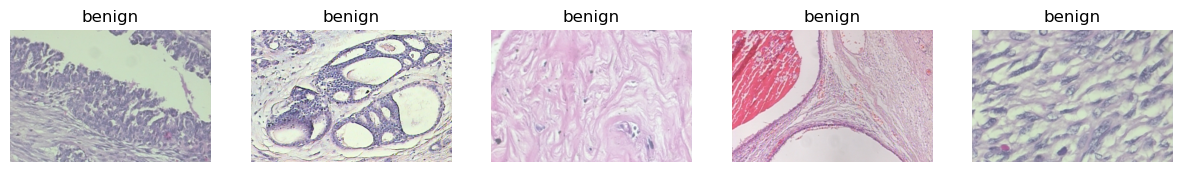

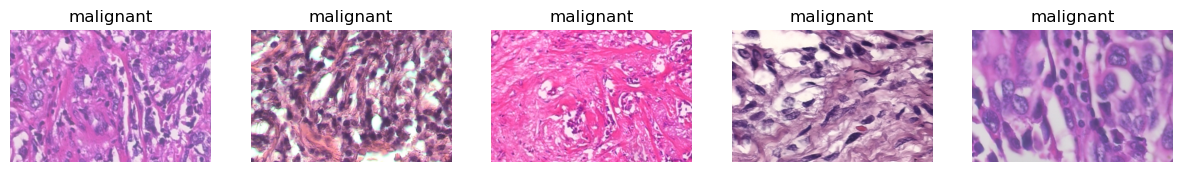

Validation dataset


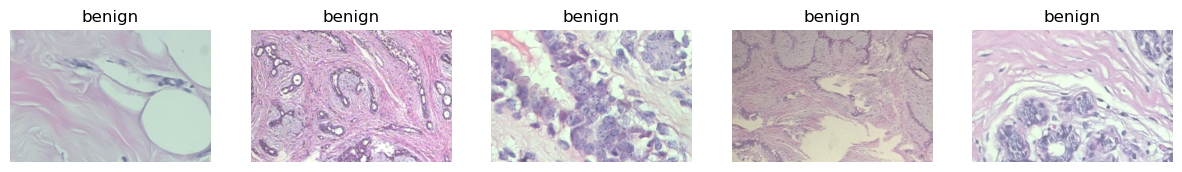

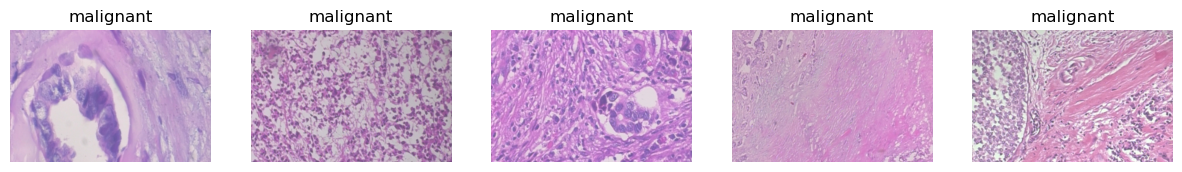

Test dataset


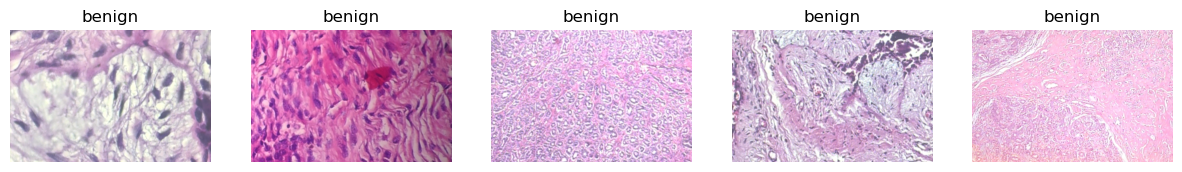

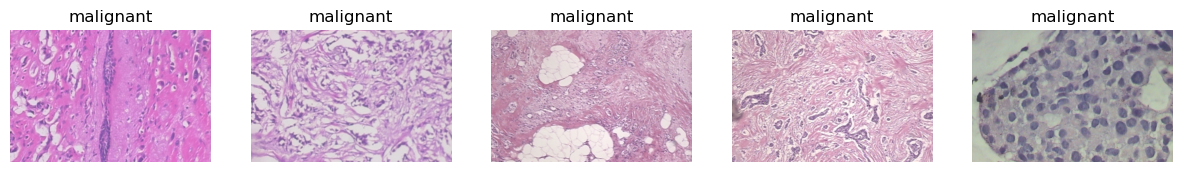

In [54]:
#plot the images
def view_samples(X, y, label_name="benign", num_samples=5):
    label = 0 if label_name == "benign" else 1
    indices = [i for i, lbl in enumerate(y) if lbl == label]
    sample_paths = random.sample([X[i] for i in indices], num_samples)

    plt.figure(figsize=(15, 3))
    for i, path in enumerate(sample_paths):
        img = Image.open(path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(label_name)
    plt.show()

# Example usage
print("Train dataset")
view_samples(X_train, y_train, label_name="benign")
view_samples(X_train, y_train, label_name="malignant")
print("Validation dataset")
view_samples(X_val, y_val, label_name="benign")
view_samples(X_val, y_val, label_name="malignant")
print("Test dataset")
view_samples(X_test, y_test, label_name="benign")
view_samples(X_test, y_test, label_name="malignant")

In [56]:
# 1A. MLP: Flatten and Standardize
X_train_mlp = X_train_final.reshape((X_train_final.shape[0], -1))
X_val_mlp = X_val_final.reshape((X_val_final.shape[0], -1))
X_test_mlp = X_test_final.reshape((X_test_final.shape[0], -1))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_mlp = scaler.fit_transform(X_train_mlp)
X_val_mlp = scaler.transform(X_val_mlp)
X_test_mlp = scaler.transform(X_test_mlp)

# 1B. CNN: No flattening or scaling, just ensure shape = (N, H, W, C)
X_train_cnn = X_train_final
X_val_cnn = X_val_final
X_test_cnn = X_test_final

In [58]:
#MLP Training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Basic training on MLP
input_shape_mlp = X_train_mlp.shape[1]         # e.g. 128*128*3 = 49,152
input_shape_cnn = X_train_cnn.shape[1:]        # (128, 128, 3)

early_stop = EarlyStopping(patience=3, restore_best_weights=True)

mlp = Sequential([
    Dense(256, activation='relu', input_shape=(input_shape_mlp,)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

mlp.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train MLP
mlp.fit(X_train_mlp, y_train_final, validation_data=(X_val_mlp, y_val_final),
        epochs=20, batch_size=64, callbacks=[early_stop])

mlp.evaluate(X_test_mlp, y_test_final)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6926 - loss: 6.0967 - val_accuracy: 0.7670 - val_loss: 0.6818
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7369 - loss: 1.1956 - val_accuracy: 0.7731 - val_loss: 0.4427
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7698 - loss: 0.5801 - val_accuracy: 0.8000 - val_loss: 0.4217
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7854 - loss: 0.4912 - val_accuracy: 0.8037 - val_loss: 0.4095
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8194 - loss: 0.4099 - val_accuracy: 0.8104 - val_loss: 0.3959
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8212 - loss: 0.3846 - val_accuracy: 0.8165 - val_loss: 0.4034
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8437 - loss: 0.3631 - val_accuracy: 0.8214 - val_loss: 0.3973
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8478 - loss: 0.3329 - val_accuracy: 0.818

[0.4144854247570038, 0.79756098985672]

Total configurations: 12

🔧 Training model 1/12: {'dropout_rate': 0.2, 'hidden_layer_sizes': (128,), 'learning_rate': 0.001}


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7097 - loss: 9.3548 - val_accuracy: 0.7884 - val_loss: 3.7526
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8364 - loss: 2.3584 - val_accuracy: 0.8024 - val_loss: 2.8028
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8739 - loss: 1.4903 - val_accuracy: 0.8141 - val_loss: 2.3684
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9066 - loss: 0.8867 - val_accuracy: 0.8269 - val_loss: 2.1096
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9283 - loss: 0.5813 - val_accuracy: 0.7774 - val_loss: 3.7973
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9219 - loss: 0.6347 - val_accuracy: 0.8092 - val_loss: 2.1428
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9347 - loss: 0.4853 - val_accuracy: 0.7933 - val_loss: 2.2522
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9506 - loss: 0.3213 - val_accu

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7135 - loss: 3.4007 - val_accuracy: 0.7859 - val_loss: 3.2322
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8124 - loss: 3.0021 - val_accuracy: 0.8153 - val_loss: 1.9789
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8800 - loss: 1.0454 - val_accuracy: 0.8373 - val_loss: 1.7533
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9144 - loss: 0.6245 - val_accuracy: 0.7755 - val_loss: 2.4592
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9272 - loss: 0.4740 - val_accuracy: 0.8257 - val_loss: 1.7845
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9358 - loss: 0.4314 - val_accuracy: 0.8000 - val_loss: 1.9025
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9478 - loss: 0.3552 - val_accuracy: 0.8080 - val_loss: 1.9972
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9535 - loss: 0.2929 - val_accuracy: 0.808

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7067 - loss: 4.9758 - val_accuracy: 0.7376 - val_loss: 0.9656
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7716 - loss: 1.0820 - val_accuracy: 0.7884 - val_loss: 0.4618
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8035 - loss: 0.4569 - val_accuracy: 0.8171 - val_loss: 0.4547
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8252 - loss: 0.3861 - val_accuracy: 0.8269 - val_loss: 0.4032
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8462 - loss: 0.3494 - val_accuracy: 0.8251 - val_loss: 0.4442
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8670 - loss: 0.3151 - val_accuracy: 0.8251 - val_loss: 0.4091
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8756 - loss: 0.2874 - val_accuracy: 0.8281 - val_loss: 0.4250
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8930 - loss: 0.2541 - val_accuracy: 0.827

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7150 - loss: 2.5071 - val_accuracy: 0.7688 - val_loss: 1.0804
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7703 - loss: 1.2998 - val_accuracy: 0.8061 - val_loss: 0.5540
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8151 - loss: 0.5686 - val_accuracy: 0.8135 - val_loss: 0.4601
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8469 - loss: 0.3764 - val_accuracy: 0.8128 - val_loss: 0.4241
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8644 - loss: 0.3211 - val_accuracy: 0.8031 - val_loss: 0.4323
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8918 - loss: 0.2763 - val_accuracy: 0.8355 - val_loss: 0.4251
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9028 - loss: 0.2433 - val_accuracy: 0.8318 - val_loss: 0.4366
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9169 - loss: 0.2132 - val_accuracy: 0.804

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7097 - loss: 4.9386 - val_accuracy: 0.7676 - val_loss: 1.3960
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7397 - loss: 1.7090 - val_accuracy: 0.7443 - val_loss: 0.5967
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7866 - loss: 0.7510 - val_accuracy: 0.7902 - val_loss: 0.5192
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8156 - loss: 0.4999 - val_accuracy: 0.8128 - val_loss: 0.5049
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8427 - loss: 0.4242 - val_accuracy: 0.8141 - val_loss: 0.4617
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8619 - loss: 0.3387 - val_accuracy: 0.8190 - val_loss: 0.4540
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8656 - loss: 0.3418 - val_accuracy: 0.8220 - val_loss: 0.4666
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8717 - loss: 0.3015 - val_accuracy: 0.825

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6927 - loss: 2.5101 - val_accuracy: 0.7535 - val_loss: 0.9707
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7706 - loss: 1.2023 - val_accuracy: 0.7890 - val_loss: 0.5073
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7843 - loss: 0.6619 - val_accuracy: 0.8043 - val_loss: 0.4597
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8196 - loss: 0.4653 - val_accuracy: 0.7841 - val_loss: 0.4908
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8343 - loss: 0.4022 - val_accuracy: 0.8177 - val_loss: 0.4583
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8557 - loss: 0.3509 - val_accuracy: 0.8190 - val_loss: 0.4693
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8600 - loss: 0.3514 - val_accuracy: 0.8183 - val_loss: 0.4936
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8756 - loss: 0.2921 - val_accuracy: 0.823

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7189 - loss: 7.2002 - val_accuracy: 0.7743 - val_loss: 4.4456
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8195 - loss: 3.3878 - val_accuracy: 0.8257 - val_loss: 2.6602
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8734 - loss: 1.5081 - val_accuracy: 0.8300 - val_loss: 2.2193
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9020 - loss: 0.9956 - val_accuracy: 0.8214 - val_loss: 2.1276
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9204 - loss: 0.6328 - val_accuracy: 0.8086 - val_loss: 2.4812
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9170 - loss: 0.6373 - val_accuracy: 0.8330 - val_loss: 1.7334
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9480 - loss: 0.3275 - val_accuracy: 0.8257 - val_loss: 1.8475
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9551 - loss: 0.2343 - val_accuracy: 0.822

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7137 - loss: 3.9936 - val_accuracy: 0.7933 - val_loss: 2.2266
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8249 - loss: 2.1504 - val_accuracy: 0.7657 - val_loss: 2.6709
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8599 - loss: 1.3794 - val_accuracy: 0.8037 - val_loss: 2.3727
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8977 - loss: 0.8571 - val_accuracy: 0.7988 - val_loss: 2.5417
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9031 - loss: 0.8370 - val_accuracy: 0.7841 - val_loss: 3.1135
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9129 - loss: 0.7139 - val_accuracy: 0.8171 - val_loss: 2.3178
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9340 - loss: 0.5858 - val_accuracy: 0.7847 - val_loss: 2.6357
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9478 - loss: 0.3102 - val_accuracy: 0.808

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6865 - loss: 6.5066 - val_accuracy: 0.7309 - val_loss: 0.9623
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7457 - loss: 1.3369 - val_accuracy: 0.7749 - val_loss: 0.4663
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7618 - loss: 0.5817 - val_accuracy: 0.8049 - val_loss: 0.4303
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8054 - loss: 0.4825 - val_accuracy: 0.7927 - val_loss: 0.4109
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8137 - loss: 0.4225 - val_accuracy: 0.8257 - val_loss: 0.3968
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8258 - loss: 0.3852 - val_accuracy: 0.8171 - val_loss: 0.3910
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8405 - loss: 0.3628 - val_accuracy: 0.8214 - val_loss: 0.3764
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8441 - loss: 0.3418 - val_accuracy: 0.828

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7069 - loss: 3.2991 - val_accuracy: 0.7945 - val_loss: 1.0501
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7594 - loss: 1.4775 - val_accuracy: 0.7982 - val_loss: 0.5269
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7945 - loss: 0.7439 - val_accuracy: 0.8104 - val_loss: 0.4549
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8170 - loss: 0.5140 - val_accuracy: 0.8067 - val_loss: 0.4120
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8266 - loss: 0.4091 - val_accuracy: 0.8306 - val_loss: 0.3975
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8421 - loss: 0.3860 - val_accuracy: 0.8190 - val_loss: 0.3971
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8526 - loss: 0.3598 - val_accuracy: 0.8190 - val_loss: 0.3849
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8779 - loss: 0.2944 - val_accuracy: 0.834

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6941 - loss: 4.1361 - val_accuracy: 0.7523 - val_loss: 0.7527
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7315 - loss: 1.2876 - val_accuracy: 0.7535 - val_loss: 0.4673
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7546 - loss: 0.6429 - val_accuracy: 0.7823 - val_loss: 0.4509
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7825 - loss: 0.5206 - val_accuracy: 0.7982 - val_loss: 0.4374
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8015 - loss: 0.4497 - val_accuracy: 0.8067 - val_loss: 0.4202
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8097 - loss: 0.4390 - val_accuracy: 0.8037 - val_loss: 0.4148
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8300 - loss: 0.4078 - val_accuracy: 0.8165 - val_loss: 0.4038
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8336 - loss: 0.3695 - val_accuracy: 0.825

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7019 - loss: 2.4343 - val_accuracy: 0.7841 - val_loss: 0.6532
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7448 - loss: 1.3175 - val_accuracy: 0.7590 - val_loss: 0.5037
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7585 - loss: 0.7544 - val_accuracy: 0.7651 - val_loss: 0.4706
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7798 - loss: 0.5766 - val_accuracy: 0.7829 - val_loss: 0.4520
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8077 - loss: 0.4702 - val_accuracy: 0.7914 - val_loss: 0.4309
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8194 - loss: 0.4315 - val_accuracy: 0.8018 - val_loss: 0.4492
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8349 - loss: 0.4086 - val_accuracy: 0.8116 - val_loss: 0.4194
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8500 - loss: 0.3382 - val_accuracy: 0.825

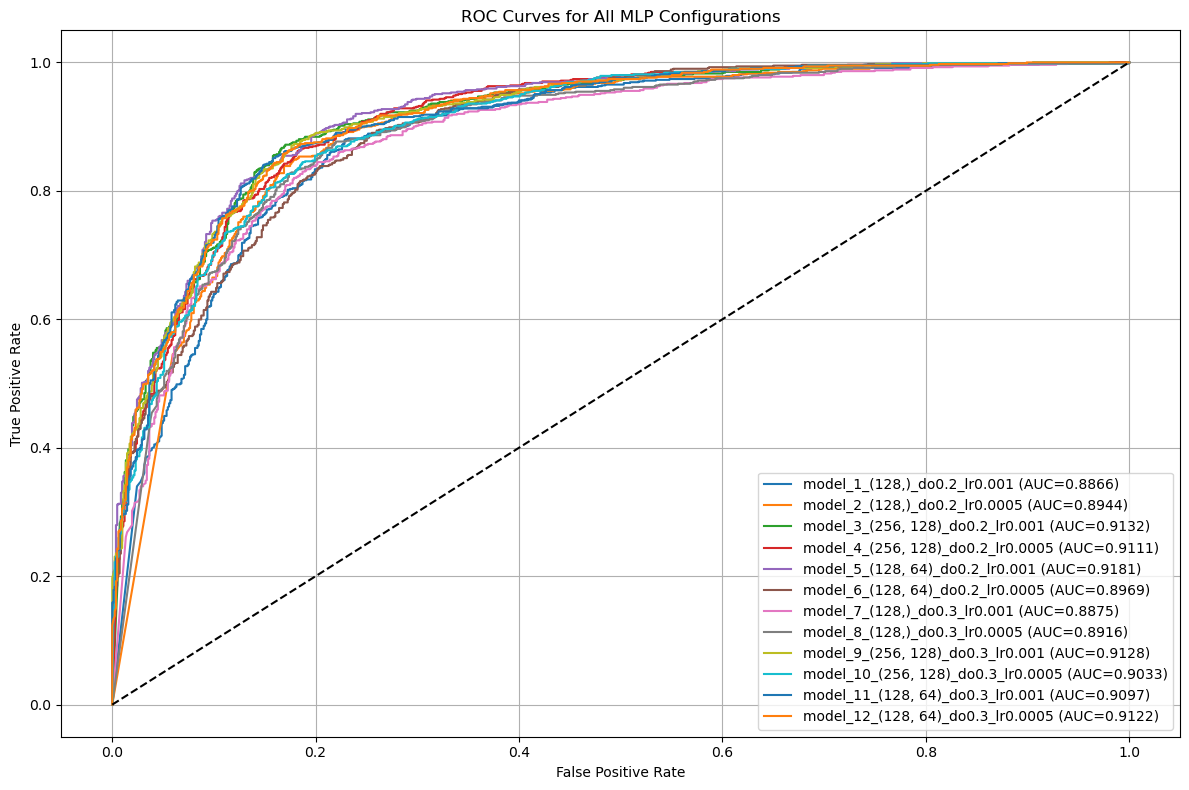


 Best Model Saved!
Best Config: {'dropout_rate': 0.2, 'hidden_layer_sizes': (128, 64), 'learning_rate': 0.001}
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       825
           1       0.83      0.86      0.84       815

    accuracy                           0.84      1640
   macro avg       0.84      0.84      0.84      1640
weighted avg       0.84      0.84      0.84      1640

Test ROC-AUC: 0.9126752184420897


In [62]:
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import pickle

def create_mlp(hidden_layer_sizes=(128, 64), dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(hidden_layer_sizes[0], activation='relu', input_shape=(X_train_mlp.shape[1],)))
    model.add(Dropout(dropout_rate))
    if len(hidden_layer_sizes) > 1:
        for units in hidden_layer_sizes[1:]:
            model.add(Dense(units, activation='relu'))
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

param_grid = {
    "hidden_layer_sizes": [(128,), (256, 128), (128, 64)],
    "dropout_rate": [0.2, 0.3],
    "learning_rate": [0.001, 0.0005],
}

configs = list(ParameterGrid(param_grid))
print(f"Total configurations: {len(configs)}")

best_auc = 0
best_model = None
best_config = None

plt.figure(figsize=(12, 8))

for i, config in enumerate(configs):
    print(f"\n🔧 Training model {i+1}/{len(configs)}: {config}")

    model = create_mlp(**config)
    history = model.fit(
        X_train_mlp, y_train_final,
        validation_data=(X_val_mlp, y_val_final),
        epochs=20,
        batch_size=64,
        verbose=1  # suppress detailed output
    )

    # Predict and compute ROC-AUC
    y_prob = model.predict(X_val_mlp).ravel()
    y_pred = (y_prob > 0.5).astype(int)
    auc = roc_auc_score(y_val_final, y_prob)
    fpr, tpr, _ = roc_curve(y_val_final, y_prob)

    config_name = f"model_{i+1}_{config['hidden_layer_sizes']}_do{config['dropout_rate']}_lr{config['learning_rate']}"
    print(f"{config_name} → AUC: {auc:.4f}")

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{config_name} (AUC={auc:.4f})")

    # Save best
    if auc > best_auc:
        best_auc = auc
        best_model = model
        best_config = config

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All MLP Configurations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save model
best_model.save("best_mlp_model.h5")

# Save config
with open("best_mlp_config.pkl", "wb") as f:
    pickle.dump(best_config, f)

print("\n Best Model Saved!")
print("Best Config:", best_config)

y_test_prob = best_model.predict(X_test_mlp).ravel()
y_test_pred = (y_test_prob > 0.5).astype(int)

print("\n Test Set Evaluation:")
print(classification_report(y_test_final, y_test_pred))
print("Test ROC-AUC:", roc_auc_score(y_test_final, y_test_prob))


In [64]:
# CNN

cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape_cnn),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

cnn.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN
cnn.fit(X_train_cnn, y_train_final, validation_data=(X_val_cnn, y_val_final),
        epochs=20, batch_size=32, callbacks=[early_stop])

cnn.evaluate(X_test_cnn, y_test_final)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.6377 - loss: 1.0651 - val_accuracy: 0.7382 - val_loss: 0.5561
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.7584 - loss: 0.5305 - val_accuracy: 0.8086 - val_loss: 0.5288
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.7437 - loss: 0.5359 - val_accuracy: 0.8110 - val_loss: 0.5233
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.7736 - loss: 0.4956 - val_accuracy: 0.8141 - val_loss: 0.4946
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.8017 - loss: 0.4695 - val_accuracy: 0.8092 - val_loss: 0.4527
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.8163 - loss: 0.4427 - val_accuracy: 0.8391 - val_loss: 0.4254
Epoch 7/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.8202 - loss: 0.4280 - val_accuracy: 0.8391 - val_loss: 0.4010
Epoch 8/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.8216 - loss: 0.4213 - 

[0.3601442277431488, 0.8719512224197388]

In [66]:

from sklearn.metrics import classification_report, roc_auc_score

mlp_preds = (mlp.predict(X_test_mlp) > 0.5).astype(int)
cnn_preds = (cnn.predict(X_test_cnn) > 0.5).astype(int)

print("MLP Classification Report:")
print(classification_report(y_test_final, mlp_preds))
print("AUC:", roc_auc_score(y_test_final, mlp.predict(X_test_mlp)))

print("CNN Classification Report:")
print(classification_report(y_test_final, cnn_preds))
print("AUC:", roc_auc_score(y_test_final, cnn.predict(X_test_cnn)))


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
MLP Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       825
           1       0.78      0.83      0.80       815

    accuracy                           0.80      1640
   macro avg       0.80      0.80      0.80      1640
weighted avg       0.80      0.80      0.80      1640

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC: 0.8885339282394497
CNN Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       825
           1       0.86      0.89      0.87       815

    accuracy                           0.87      1640
   macro avg       0.87      0.87      0.87      1640
weighted avg       0.87      0.87      0.87      1640

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
AUC: 0.9332887153746049


In [ ]:
# KNN

from sklearn.neighbors import KNeighborsClassifier 

# 1. Flatten Images
X_train_flat_knn = X_train_final.reshape(X_train_final.shape[0], -1)
X_val_flat_knn = X_val_final.reshape(X_val_final.shape[0], -1)
X_test_flat_knn = X_test_final.reshape(X_test_final.shape[0], -1)

# 2. Normalize Pixel Values 
# X_train_knn = X_train_flat_knn / 255.0
# X_val_knn = X_val_flat_knn / 255.0
# X_test_knn = X_test_flat_knn / 255.0

scaler = StandardScaler()
X_train_knn = scaler.fit_transform(X_train_flat_knn)
X_val_knn = scaler.transform(X_val_flat_knn)
X_test_knn = scaler.transform(X_test_flat_knn)

# 3. Tune n_neighbors parameter
knnModel = KNeighborsClassifier()
params = {'n_neighbors': list(range(1,20)),
         'weights': ['uniform', 'distance'],
         'metric': ['minkowski', 'euclidean', 'manhattan']}

# use accuracy since dataset is balanced
gridSearch = GridSearchCV(knnModel, params, cv=5, scoring='accuracy') 
gridSearch.fit(X_train_knn, y_train_final)

In [ ]:
# Make predictions
print(f"Optimal n_neighbors: {gridSearch.best_params_['n_neighbors']}")
print(f"Optimal weights: {gridSearch.best_params_['weights']}")
print(f"Optimal metric: {gridSearch.best_params_['metric']}")

y_pred_val_knn = gridSearch.predict(X_val_knn)
y_pred_test_knn = gridSearch.predict(X_test_knn)

In [127]:
# Print Reports

print("KNN - Report for Validation Dataset")
print(classification_report(y_val_final, y_pred_val_knn))
print("AUC:", roc_auc_score(y_val_final, y_pred_val_knn))

print("KNN - Report for Test Dataset")
print(classification_report(y_test_final, y_pred_test_knn))
print("AUC:", roc_auc_score(y_test_final, y_pred_test_knn))

KNN - Report for Validation Dataset
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       823
           1       0.73      0.77      0.75       812

    accuracy                           0.75      1635
   macro avg       0.75      0.75      0.75      1635
weighted avg       0.75      0.75      0.75      1635

AUC: 0.7475825856382694
KNN - Report for Test Dataset
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       825
           1       0.72      0.78      0.75       815

    accuracy                           0.74      1640
   macro avg       0.74      0.74      0.74      1640
weighted avg       0.74      0.74      0.74      1640

AUC: 0.7423052612009667


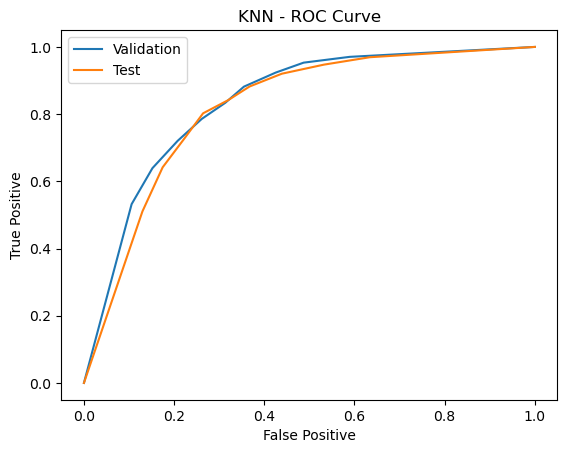

In [122]:
# Plot ROC curve

y_pred_val_prob_knn = gridSearch.predict_proba(X_val_knn)[:,1] # single out one class 
y_pred_test_prob_knn = gridSearch.predict_proba(X_test_knn)[:,1]

fpr_val, tpr_val, _ = roc_curve(y_val_final, y_pred_val_prob_knn)
plt.plot(fpr_val, tpr_val, label="Validation")

fpr_test, tpr_test, _ = roc_curve(y_test_final, y_pred_test_prob_knn)
plt.plot(fpr_test, tpr_test, label="Test")

plt.title("KNN - ROC Curve")
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.legend()
plt.show()